In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import random
import matplotlib.patches as mpatches
import umap
import numpy as np
from torch import nn
import torch.nn.functional as F
import pandas as pd
import torch
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

c:\Users\heetp\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, proj_dim):
        super(FeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        # self.bn1 = nn.BatchNorm1d(hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc = nn.Linear(32, proj_dim)

    def forward(self, x, compute_losses=False):
        x1 = self.fc1(x)
        x = F.leaky_relu(x1)
        # x = self.bn1(x)
        x = F.dropout(x, p=0.2)
        # x = F.leaky_relu(self.fc2(x))
        x = self.bn2(x)
        if compute_losses:
            projected_features = F.normalize(self.fc(x), p=2, dim=1)
            return x, projected_features
        return x


class FeatureDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, proj_dim):
        super(FeatureDecoder, self).__init__()
        # self.fc1 = nn.Linear(proj_dim, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc = nn.Linear(32, input_dim)

    def forward(self, x):
        # print(x.shape)
        # x = self.fc1(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.fc(x)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:

def load_client_data(client_folder):
    normal_path = os.path.join(client_folder, "normal", "data.csv")
    abnormal_path = os.path.join(client_folder, "abnormal", "data.csv")
    test_normal_path = os.path.join(client_folder, "test_normal", "data.csv")
    print(normal_path)
    normal_data = pd.read_csv(normal_path, header=None)
    abnormal_data = pd.read_csv(abnormal_path, header=None)
    test_normal_data = pd.read_csv(test_normal_path, header=None)
    normal_data['label'] = 0
    abnormal_data['label'] = 1
    test_normal_data['label'] = 0
    print(normal_data.shape[0])
    print(abnormal_data.shape[0])
    print(test_normal_data.shape[0])
    train_normal = normal_data.sample(n=1000, random_state=42)
    train_abnormal = abnormal_data.sample(n=3, random_state=42)
    train_df = pd.concat([train_normal, train_abnormal], ignore_index=True)
    test_normal = test_normal_data.sample(n=100, random_state=42)
    test_abnormal = abnormal_data.drop(train_abnormal.index).sample(n=50, random_state=42)
    test_df = pd.concat([test_normal, test_abnormal], ignore_index=True)
    return train_df, test_df

def correlation_loss(features):
    batch_mean = torch.mean(features, dim=0, keepdim=True)
    batch_std = torch.std(features, dim=0, keepdim=True) + 1e-8
    normalized_features = (features - batch_mean) / batch_std
    cov_matrix = torch.matmul(normalized_features.T, normalized_features) / (features.size(0) - 1)
    off_diag = cov_matrix - torch.diag(torch.diag(cov_matrix))
    loss = torch.sum(off_diag ** 2)
    return loss

def latent_space_equalization_loss(features):
    features = F.normalize(features, p=2, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    batch_size = features.size(0)
    probs = F.softmax(similarity_matrix / 0.1, dim=1)
    entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1).mean()
    return -entropy

def set_seed(random_no):
    np.random.seed(random_no)
    random.seed(random_no)
    torch.manual_seed(random_no)
    torch.cuda.manual_seed(random_no)
    torch.cuda.manual_seed_all(random_no)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
set_seed(100)
reducer = umap.UMAP(n_components=2, random_state=110)
def plot_latent_features(name, latent_tensor, batch_y):
    if isinstance(latent_tensor, torch.Tensor):
        latent_np = latent_tensor.detach().cpu().numpy()
    else:
        latent_np = latent_tensor

    if isinstance(batch_y, torch.Tensor):
        batch_y = batch_y.detach().cpu().numpy()

    label_map = {1: 'Malware', 0: 'Benign'}
    labels = np.vectorize(label_map.get)(batch_y)

    latent_2d = reducer.fit_transform(latent_np)
    sns.kdeplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, fill=True, alpha=0.5, thresh=0.05, palette={"Malware":"#ff891a", "Benign":"#1f77b4"})
    plt.xticks(fontsize=15, fontweight='bold')
    plt.yticks(fontsize=15, fontweight='bold')

    benign_patch = mpatches.Patch(color='#1f77b4', label='Benign')
    malware_patch = mpatches.Patch(color='#ff891a', label='Malware')

    legend = plt.legend(handles=[benign_patch, malware_patch], fontsize=15, loc='upper right', title=None)
    for text in legend.get_texts():
        text.set_fontweight('bold')
    plt.show()

In [7]:
set_seed(100)
all_metrics = []
# FLM model params
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.001
OPTIMIZER = 'AdamW'
LOSS = 'LatentSpaceEqualizationLoss & Correlation Loss'

# FCL params
CLASSIFIER_EPOCHS = 50
CLASSIFIER_BATCH_SIZE = 512
CLASSIFIER_LEARNING_RATE = 0.001
CLASSIFIER_WEIGHT_DECAY = 0.01
CLASSIFIER_CRITERION = 'CrossEntropyLoss'
CLASSIFIER_OPTIMIZER = 'AdamW'

# fl params
NUM_CLIENTS = 10
NUM_ROUNDS = 5
AGGREGATION = 'FedDyn'
PERCENTAGE = 50 #percentage of clients participation in training

TRAINING_TYPE = 'Decentralized'
SAVE = False
train, test = load_client_data("E:/fedmse-main/Data/Scenarios_dataset/Scenarios_dataset/nonIID-50-Client_Data/Client-1")
y_train = train['label']
X_train = train.drop(columns=['label'])
del train
y_test = test['label']
X_test = test.drop(columns=['label'])
del test

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)
encoder = FeatureExtractor(input_dim=X_train.shape[1], hidden_dim=128, proj_dim=64).to(device)
decoder = FeatureDecoder(input_dim=X_train.shape[1], hidden_dim=128, proj_dim=64).to(device)
print(type(X_train))
optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
dataset = torch.utils.data.TensorDataset(X_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
encoder.train()
decoder.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in dataloader:
        x = batch[0].to(device)
        encoded = encoder(x)
        x_recon = decoder(encoded)
        loss = nn.MSELoss(reduction='mean')(x, x_recon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

feature_extractor = FeatureExtractor(input_dim=X_train.shape[1], hidden_dim=128, proj_dim=64)
optimizer = optim.AdamW(feature_extractor.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
feature_extractor.train()
dataset = torch.utils.data.TensorDataset(X_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch in dataloader:
        batch_data = batch[0].to(device)
        optimizer.zero_grad()
        features, projected_features = feature_extractor(batch_data, compute_losses=True)
        corr_loss = correlation_loss(features)
        latent_loss = latent_space_equalization_loss(projected_features)
        loss = corr_loss + latent_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

E:/fedmse-main/Data/Scenarios_dataset/Scenarios_dataset/nonIID-50-Client_Data/Client-1\normal\data.csv
1302
4983
755
<class 'torch.Tensor'>
Epoch 1/100, Loss: 1.2887
Epoch 11/100, Loss: 1.1809
Epoch 21/100, Loss: 1.1061
Epoch 31/100, Loss: 1.0245
Epoch 41/100, Loss: 0.9805
Epoch 51/100, Loss: 0.9199
Epoch 61/100, Loss: 0.8828
Epoch 71/100, Loss: 0.8304
Epoch 81/100, Loss: 0.8027
Epoch 91/100, Loss: 0.7792
Epoch 0, Loss: 277.12242126464844
Epoch 10, Loss: 205.77058792114258
Epoch 20, Loss: 189.09419631958008
Epoch 30, Loss: 144.85841751098633
Epoch 40, Loss: 126.06325912475586
Epoch 50, Loss: 117.74642181396484
Epoch 60, Loss: 105.57252883911133
Epoch 70, Loss: 89.24600028991699
Epoch 80, Loss: 85.71138000488281
Epoch 90, Loss: 82.33756446838379


Reconstruction Loss


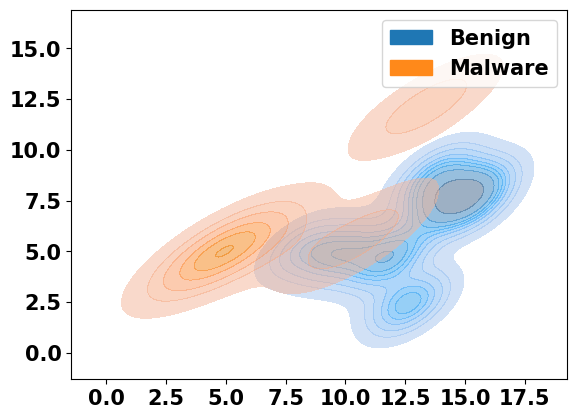

Correlation Loss + Latent Space Equalization Loss


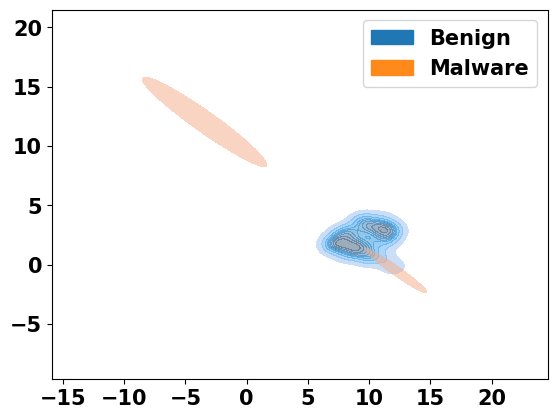

In [8]:
set_seed(100)
encoded_test = encoder(X_test)
feature_extractor_test, projected_feature_test = feature_extractor(X_test, compute_losses=True)
print("Reconstruction Loss")
plot_latent_features("reconstruction", encoded_test, y_test)
print("Correlation Loss + Latent Space Equalization Loss")
plot_latent_features("our loss",projected_feature_test, y_test)

Epoch 0, Loss: 10.723358154296875
Epoch 10, Loss: 8.138111114501953
Epoch 20, Loss: 6.483942627906799
Epoch 30, Loss: 5.498933434486389
Epoch 40, Loss: 4.627370357513428
Epoch 50, Loss: 3.9966062903404236
Epoch 60, Loss: 3.496316075325012
Epoch 70, Loss: 3.4514120221138
Epoch 80, Loss: 3.1741971373558044
Epoch 90, Loss: 2.985213279724121
Latent Space Equalization Loss


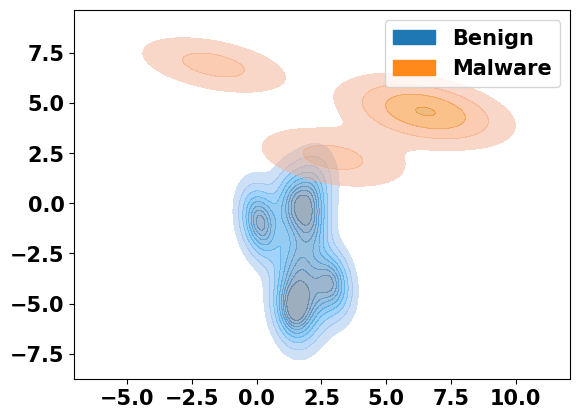

Epoch 0, Loss: 287.8796730041504
Epoch 10, Loss: 212.38895416259766
Epoch 20, Loss: 153.7272071838379
Epoch 30, Loss: 128.26474952697754
Epoch 40, Loss: 106.15091133117676
Epoch 50, Loss: 100.01346015930176
Epoch 60, Loss: 96.93408966064453
Epoch 70, Loss: 89.48763275146484
Epoch 80, Loss: 82.07734298706055
Epoch 90, Loss: 83.62823677062988
Correlation Loss


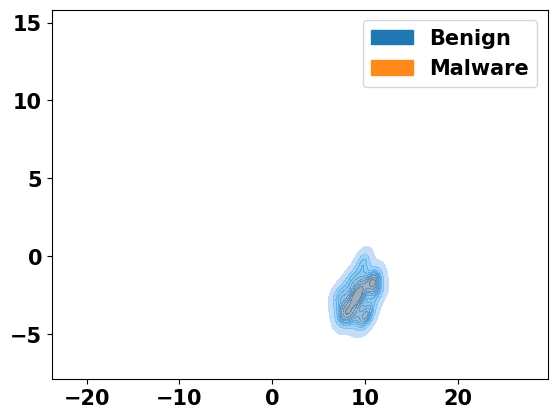

In [9]:
set_seed(100)
feature_extractor = FeatureExtractor(input_dim=X_train.shape[1], hidden_dim=128, proj_dim=64)
optimizer = optim.AdamW(feature_extractor.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
feature_extractor.train()
dataset = torch.utils.data.TensorDataset(X_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch in dataloader:
        batch_data = batch[0].to(device)
        optimizer.zero_grad()
        features, projected_features = feature_extractor(batch_data, compute_losses=True)
        corr_loss = correlation_loss(features)
        latent_loss = latent_space_equalization_loss(projected_features)
        loss = abs(latent_loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")
feature_extractor_test, projected_feature_test = feature_extractor(X_test, compute_losses=True)
print("Latent Space Equalization Loss")
plot_latent_features("our loss",projected_feature_test, y_test)

feature_extractor = FeatureExtractor(input_dim=X_train.shape[1], hidden_dim=128, proj_dim=64)
optimizer = optim.AdamW(feature_extractor.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
feature_extractor.train()
dataset = torch.utils.data.TensorDataset(X_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch in dataloader:
        batch_data = batch[0].to(device)
        optimizer.zero_grad()
        features, projected_features = feature_extractor(batch_data, compute_losses=True)
        corr_loss = correlation_loss(features)
        latent_loss = latent_space_equalization_loss(projected_features)
        loss = corr_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")
feature_extractor_test, projected_feature_test = feature_extractor(X_test, compute_losses=True)
print("Correlation Loss")
plot_latent_features("our loss",projected_feature_test, y_test)